In [1]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load Annotations

In [2]:
train_dir = "dataset/train"
valid_dir = "dataset/valid"
test_dir = "dataset/test"

In [3]:
train_file = glob.glob(f"{train_dir}/*.json")
train_file

['dataset/train\\_annotations.coco.json']

In [4]:
json.load(open(train_file[0])).keys()   # Remove .keys(), if you want to print the whole json file

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [5]:
valid_file = glob.glob(f"{valid_dir}/*.json")
test_file = glob.glob(f"{test_dir}/*.json")

In [6]:
train_annot = json.load(open(train_file[0]))
valid_annot = json.load(open(valid_file[0]))
test_annot = json.load(open(test_file[0]))

In [7]:
print(train_annot.keys())
print(valid_annot.keys())
print(test_annot.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


# Access images and segmentation data

In [8]:
len(train_annot["images"])

1502

In [9]:
idx = 1003

train_annot["images"][idx]

{'id': 1003,
 'license': 1,
 'file_name': '170_jpg.rf.243dbc079c83ebc2b6206b214abbdd1e.jpg',
 'height': 640,
 'width': 640,
 'date_captured': '2023-08-19T04:37:54+00:00'}

In [10]:
img_name = train_annot["images"][idx]["file_name"]

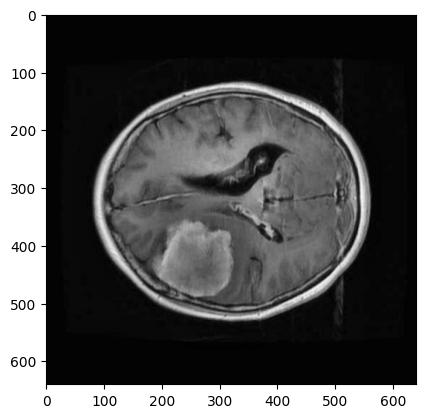

In [11]:
sample_train_img = cv2.imread(f"{train_dir}/{img_name}")
plt.imshow(sample_train_img)

In [12]:
train_annot["annotations"][idx]

{'id': 1003,
 'image_id': 1003,
 'category_id': 2,
 'bbox': [189, 340, 142.5, 162.5],
 'area': 23156.25,
 'segmentation': [[331.25,
   340,
   188.75,
   340,
   188.75,
   502.5,
   331.25,
   502.5,
   331.25,
   340]],
 'iscrowd': 0}

In [13]:
bbox = train_annot["annotations"][idx]["bbox"]
bbox = np.array(bbox, dtype=np.int32)
x, y, w, h =  bbox

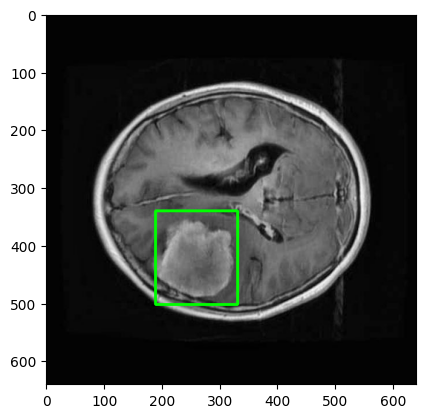

In [14]:
cv2.rectangle(sample_train_img, (x, y), (x+w, y+h), (0,255,0), 3)
plt.imshow(sample_train_img)

In [15]:
num_images = 9

indices = np.random.randint(0, len(train_annot["images"]), size = num_images)
indices

array([1392,  589,  215,   70,  555,  375,  457, 1243,  480])

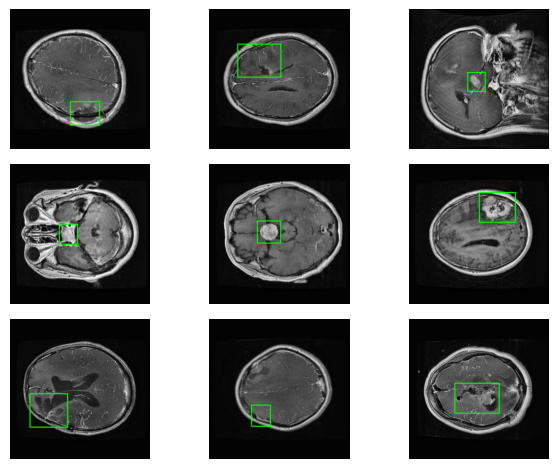

In [16]:
for i, idx in enumerate(indices):

    # Read image filename
    img_name = train_annot["images"][idx]["file_name"]

    # Load image
    sample_train_img = cv2.imread(f"{train_dir}/{img_name}")

    # Get Bounding box coordinates
    bbox = train_annot["annotations"][idx]["bbox"]
    bbox = np.array(bbox, dtype=np.int32)
    x, y, w, h =  bbox

    # Draw bounding box
    cv2.rectangle(sample_train_img, (x, y), (x+w, y+h), (0,255,0), 3)

    # Display image
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(sample_train_img)



# Create ground truths for training

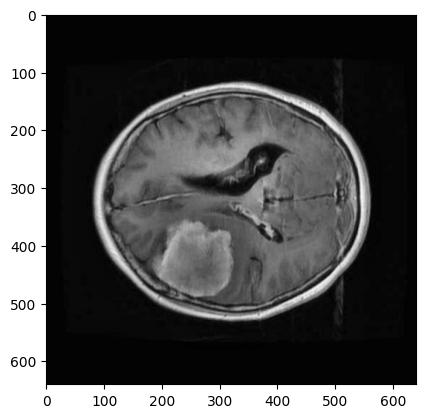

In [17]:
train_dir = "dataset/train"

train_annot = json.load(open(glob.glob(f"{train_dir}/*.json")[0]))

idx = 1003
img_name = train_annot["images"][idx]["file_name"]

sample_train_img = cv2.imread(f"{train_dir}/{img_name}")
plt.imshow(sample_train_img)

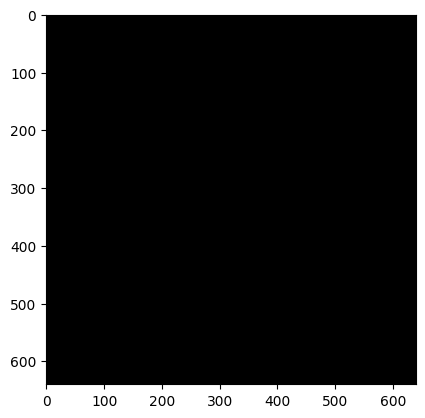

In [18]:
mask = np.zeros((sample_train_img.shape[0], sample_train_img.shape[1]), dtype=np.uint8)
plt.imshow(mask, cmap="gray")

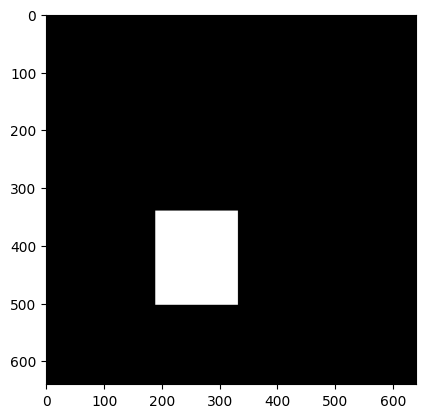

In [19]:
bbox = train_annot["annotations"][idx]["bbox"]
bbox = np.array(bbox, dtype=np.int32)
x, y, w, h =  bbox

cv2.rectangle(mask, (x, y), (x+w, y+h), (255,255,255), -1)
plt.imshow(mask, cmap="gray")

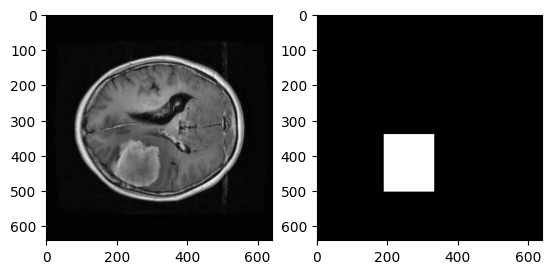

In [20]:
plt.subplot(121)
plt.imshow(sample_train_img)
plt.subplot(122)
plt.imshow(mask, cmap="gray")

In [21]:
#cv2.imwrite("sample_mask.jpg", mask)

In [22]:
train_mask_dir = "dataset/train_mask"

In [23]:
import os

os.path.exists(train_mask_dir)

True

In [24]:
if os.path.exists(train_mask_dir) == False:
    os.mkdir(train_mask_dir)
    print("train_mask directory created. Loading masks....")
    cv2.imwrite(f"{train_mask_dir}/sample_mask.jpg", mask)
    print("Done")
else:
    print("train_mask directory already exists")

train_mask directory already exists


In [25]:
if os.path.exists(train_mask_dir) == False:
    
    os.mkdir(train_mask_dir)
    print("train_mask directory created. Loading masks....")

    for idx in range(3):
    
        img_name = train_annot["images"][idx]["file_name"]
        sample_train_img = cv2.imread(f"{train_dir}/{img_name}")

        mask = np.zeros((sample_train_img.shape[0], sample_train_img.shape[1]), dtype=np.uint8)

        bbox = train_annot["annotations"][idx]["bbox"]
        bbox = np.array(bbox, dtype=np.int32)
        x, y, w, h =  bbox
        cv2.rectangle(mask, (x, y), (x+w, y+h), (255,255,255), -1)

        cv2.imwrite(f"{train_mask_dir}/mask_{img_name}", mask)

    print("Done")

else:
    print("train_mask directory already exists")

train_mask directory already exists


# Pre-process images before training

In [26]:
target_size = (128, 128)

X_train =  [cv2.resize(cv2.imread(train_dir + "/" + image['file_name']),target_size) for image in train_annot['images']]
y_train = [cv2.resize(cv2.imread(train_mask_dir + "/mask_" +image['file_name'],cv2.IMREAD_GRAYSCALE),target_size ) for image in train_annot['images']]

In [27]:
X_train = np.array(X_train)
y_train = np.expand_dims(np.array(y_train), axis=-1)

In [28]:
np.unique(y_train)

array([  0,   1,   2,   3,   4,   5,   7, 249, 250, 251, 252, 253, 254,
       255], dtype=uint8)

In [29]:
X_train = X_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0

In [30]:
np.unique(y_train)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02745098, 0.9764706 , 0.98039216, 0.9843137 ,
       0.9882353 , 0.99215686, 0.99607843, 1.        ], dtype=float32)

In [31]:
y_train = (y_train > 0.5).astype(np.float32)

In [32]:
np.unique(y_train)

array([0., 1.], dtype=float32)

In [33]:
X_train.shape

(1502, 128, 128, 3)

In [34]:
y_train.shape

(1502, 128, 128, 1)

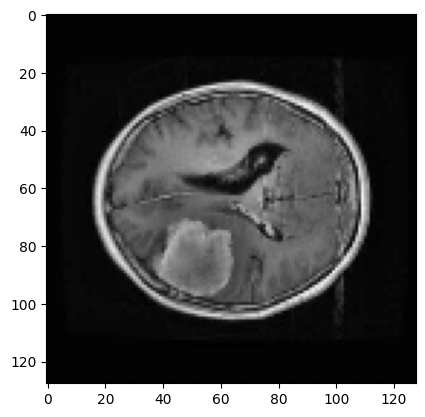

In [35]:
plt.imshow(X_train[idx])

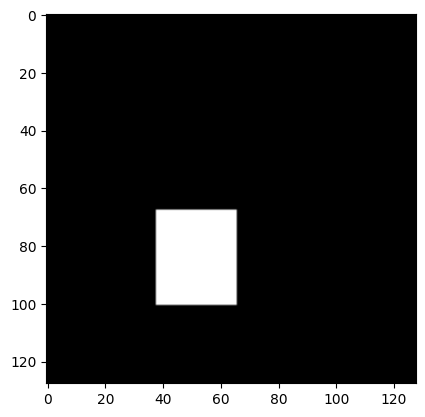

In [36]:
plt.imshow(y_train[idx], cmap="gray")

# Testing `preprocess.py`

In [37]:
from preprocess import load_data

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()

Loading preprocessed dataset ....
Done


In [38]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1502, 128, 128, 3)
(1502, 128, 128, 1)
(429, 128, 128, 3)
(429, 128, 128, 1)
(215, 128, 128, 3)
(215, 128, 128, 1)


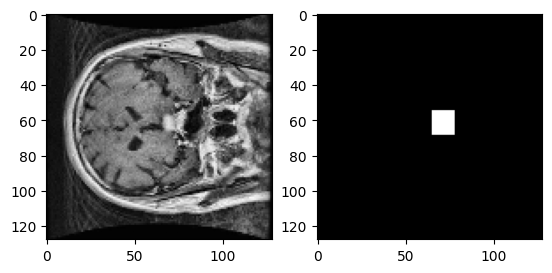

In [39]:
idx=128

plt.subplot(121)
plt.imshow(X_train[idx])
plt.subplot(122)
plt.imshow(Y_train[idx], cmap="gray")

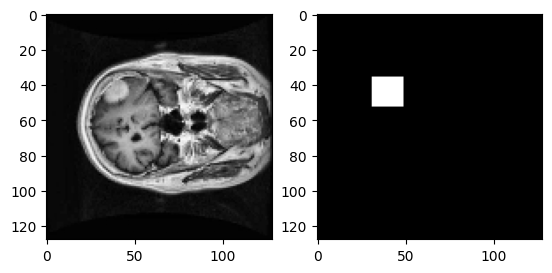

In [40]:
idx = 200

plt.subplot(121)
plt.imshow(X_val[idx])
plt.subplot(122)
plt.imshow(Y_val[idx], cmap="gray")

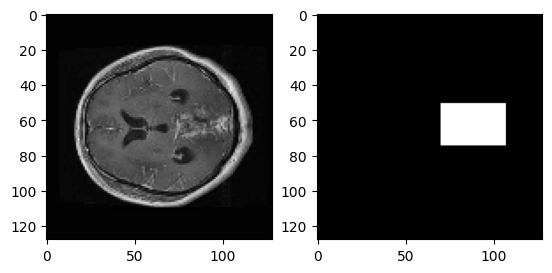

In [41]:
idx = 80

plt.subplot(121)
plt.imshow(X_test[idx])
plt.subplot(122)
plt.imshow(Y_test[idx], cmap="gray")